In [1]:
# Data packages
import pandas as pd 
import os
import matplotlib.pyplot as plt


import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from model.rnn import GRUDecoder, SimpleDecoder
from model.autoencoder import AutoEncoder, SimpleAutoEncoder
from data_processing.pipeline import encoding_pipeline, get_generic_name

In [2]:
def get_device():
    # Check if CUDA is available
    if torch.cuda.is_available():
        # If CUDA is available, select the first CUDA device
        device = torch.device("cuda:0")
        print("Using CUDA device:", torch.cuda.get_device_name(0))
    # Check for MPS availability on supported macOS devices (requires PyTorch 1.12 or newer)
    elif torch.backends.mps.is_available():
        # If MPS is available, use MPS device
        device = torch.device("mps")
        print("Using MPS (Metal Performance Shaders) device")
    else:
        # Fallback to CPU if neither CUDA nor MPS is available
        device = torch.device("cpu")
        print("Using CPU")
    return device
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [3]:
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv")
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

/var/folders/pk/3vzybg253k1d3n7qzxkts_2c0000gn/T/ipykernel_8976/1529815470.py:2: DtypeWarning: Columns (2583,2584,2585,2586,2587,2588,2589,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371,4372,4373,4374,4375,4379,4380,4381,4382,4383,4384,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399,4400,4401,4405,4406,4407,4408,4409,5215,5216,5219,5220,5613,5614,5615,5616,5617,5618,5619,5620,5621,5622,5624,5625,5626,5627,5628,5629,5630,5631,5632,5633,5634,5635,5636,5638,5639,5640,5787,5788,5789,5790,5791,5792,5793,5794,5795,5796,6393,6394,6395,6396,6397,6398,6399,6400,6401,6402,6403,6619,6620,6621,6622,6623,6624,6625,6626,6627,6628,6629,6630,6631,6632,6633,6634,6635,6638,6640,6641,6642,6643,6644,6645,6646,6647,6648,6649,6650,6651,6652,6653,6654,6655,6656,6657,6658,6659,6660,6661,6664,6666,6667,6668,6669,6670,6965,6966,6967,6968,6969,6970,6971,6972,6973,6974,6975,7064,7065,7066,7067,7068,7069,7070,7071,7072,7073,7074,7163,7164,7165,7166,7167,7168,7169,7

### Select the top 10 most important questions (there's overlap, so there's only gonna be 8)

In [4]:
importance = pd.read_csv('features_importance_1000.csv')
custom_pairs = importance.iloc[:50].feature.map(lambda x: get_generic_name(x))

In [5]:
# check if sequences have been preprocessed (saves time)
if False:# os.path.exists('data/processed_data/sequences.pt'):
    sequences = torch.load('data/processed_data/sequences.pt')
else:
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    #torch.save(sequences, 'data/processed_data/sequences.pt')

/Users/carlomarx/Documents/GitHub/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


# Train the SIMPLE Autoencoder

In [6]:
from model.dataset import PretrainingDataset
pretrain_dataset = PretrainingDataset(sequences)

In [7]:
### Initialization of the Autoencoder 
HIDDEN_DIM = 128
#ENCODING_SIZE = 64
BATCH_SIZE = 96
num_epochs_autoencoder = 2
learning_rate_autoencoder = 5e-2

SEQ_LEN = pretrain_dataset.get_seq_len()
vocab_size = pretrain_dataset.get_vocab_size()

train_dataloader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder = SimpleAutoEncoder(vocab_size=vocab_size, embedding_size=HIDDEN_DIM, sequence_len=SEQ_LEN).to(device)

#loss_f1 = nn.HuberLoss(delta=1.0)
loss_cls = nn.CrossEntropyLoss()
#loss_cos = nn.CosineEmbeddingLoss()
optimizer = optim.RAdam( autoencoder.parameters(), lr = learning_rate_autoencoder, weight_decay=1e-2, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs_autoencoder, eta_min = 1e-5, last_epoch = -1)

/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### (or) Train the autoencoder

In [ ]:
# Slows down the training but allows use to detect nan
DETECT_ANOMALY = True

In [ ]:
""" INPUT MODEL NAME BELOW (FOR CHECKPOINTS)"""
model_name = "foo"

autoencoder.train()
autoencoder.to(device)
loss_metric = []
all_loss = []   # for plotting
######## ANNOMALY DETECTION
torch.autograd.set_detect_anomaly(DETECT_ANOMALY)

for epoch in range(num_epochs_autoencoder):
    loss_epoch_metric = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, (year, seq) in loop_object :
        optimizer.zero_grad()
        year = year.to(device)
        seq = seq.to(device)

        x= autoencoder(year, seq)
        loss = loss_cls(x.permute(0,2,1), seq.long()) #+ #+ loss_cos(x1.reshape(x1.size(1) * x1.size(0), -1 ), 
                                                       #         autoencoder.embedding(year, seq).view(x1.size(1) * x1.size(0), -1), 
                                                        #        torch.ones(seq.size(0) * seq.size(1)).to(device))
         #+ 0.7 * loss_f1(x1, autoencoder.embedding(year, seq)) +  
        loss_epoch_metric.append(loss.detach().cpu().numpy())
        all_loss.append(loss_epoch_metric[-1])
        loss.backward()
        optimizer.step()
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_epoch_metric[-100:]))
    ## After epoch end
    scheduler.step()
    loss_metric.append(np.mean(loss_epoch_metric))
    print(f'epoch {epoch} \t Loss: {loss_metric[-1]:.4g} and LR: {scheduler.get_last_lr()[0]:.5g}')
    torch.save(autoencoder.state_dict(), f'weights/{model_name}_{epoch}.pt')

In [ ]:

plt.plot(all_loss)
plt.show()

### Explroe the embedding space

In [8]:
### FAST CHECK
print("Answer Embedding has %s NaNs" %torch.isnan(autoencoder.embedding.answer_embedding.weight).sum().cpu().numpy())
print("Year Embedding has %s NaNs" %torch.isnan(autoencoder.embedding.yearly_embedding.weight).sum().cpu().numpy())

Answer Embedding has 0 NaNs
Year Embedding has 0 NaNs


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


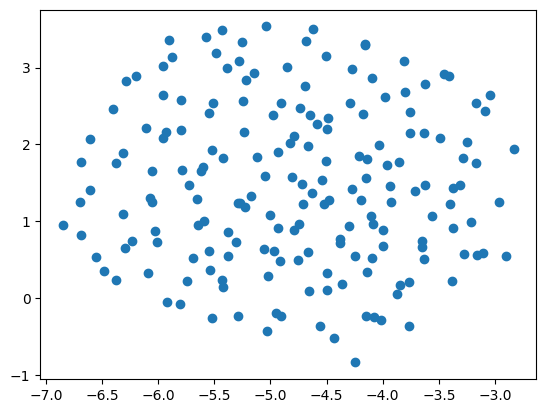

In [9]:
import umap
import matplotlib.pyplot as plt
w = autoencoder.embedding.answer_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1])
plt.show()

# Train the RNN

First we need to create Dataset class that can hold both the target (stored in a pd.DataFrame) and the sequences.

The sequences will be of dimension 14 x encoding_dimension, because we have 14 years of surveys.

I have created some code for getting the data into the right format, but it might not be useful.

## Regarding masks
Right now the masking is done already in the encoding. I haven't found exactly where Mikkel implemented this.
So for now, assume that nothing is padded, and then we'll figure it out with Mikkel.

In [8]:
# its not everyone we have a target for, so we do restrict the data to 
# the ones with known outcomes
targets = targets[targets.new_child.notna()]
train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

In [9]:
rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

In [10]:
# split data based on the splits made for the target
train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

In [11]:
from model.dataset import FinetuningDataset
train_dataset = FinetuningDataset(train_data, targets = targets)
test_dataset = FinetuningDataset(test_data, targets = targets)

rnn_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)

In [18]:
# ft - fine-tuning

HIDDEN_SIZE = 64
ENCODING_SIZE = 32

num_epochs_ft = 40
learning_rate_ft = 5e-3

aggregator = nn.Sequential(
    nn.LazyInstanceNorm1d(),
    nn.LazyLinear(ENCODING_SIZE),
    nn.LazyBatchNorm1d()).to(device)

######## WHAT we used initialy
decoder = GRUDecoder(
    input_size=ENCODING_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_seq_len=14
).to(device)

#### Simple RNN
decoder = decoder = GRUDecoder(
    input_size=ENCODING_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_seq_len=14,
    dropout=0.01,
    bidirectional= False, 
    num_layers=1,
    with_attention= True,
    xavier_initialization=True,
).to(device)


##### SIMPLE DECODER with AVERGING
#decoder = SimpleDecoder(input_size=ENCODING_SIZE, output_size=1).to(device)

# Define loss function and optimizer for RNN
ft_loss = torch.nn.BCELoss()
ft_optimizer = torch.optim.RAdam(list(decoder.parameters()) + list(autoencoder.parameters()) + list(aggregator.parameters()) , lr=learning_rate_ft, weight_decay=1e-3, decoupled_weight_decay=True)
ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-6, last_epoch = -1)

# Training loop
decoder.train()
autoencoder.train()
aggregator.train()
print("Ready!")

The model is going to set all input MASK to None
The model is going to set all input MASK to None
Ready!


/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
NUM_COLS = 44

In [20]:
loss_per_epoch = []
for epoch in range(num_epochs_ft):
    # print(epoch)
    loss_per_step = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, batch in loop_object :        
        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = autoencoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        survey_emb = aggregator(encodings)
        mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()

        # Forward pass
        xx = decoder(survey_emb, mask)
        outputs = torch.nn.functional.sigmoid(xx)

        loss = ft_loss(torch.flatten(outputs), labels)  
        loss_per_step.append(loss.detach().cpu().numpy())
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))

        #loss.backward(retain_graph=True)
        loss.backward()
        ft_optimizer.step()
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    ft_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs_ft}, Loss: {loss_per_epoch[-1]:.4f}")
    

Epochs 0: 50it [00:05,  9.65it/s, mean loss: 0.458]


Epoch 1/40, Loss: 0.4584


Epochs 1: 50it [00:03, 14.74it/s, mean loss: 0.220]


Epoch 2/40, Loss: 0.2200


Epochs 2: 15it [00:01, 14.04it/s, mean loss: 0.127]


KeyboardInterrupt: 

In [36]:
y, z = decoder.gru(survey_emb)

In [39]:
y.shape

torch.Size([16, 14, 64])

In [26]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

val_loss = []
preds = []
targets = []

## Set both models into the eval mode.=
rnn_model.eval()
autoencoder.eval()
for batch in test_dataloader:
    inputs, labels = batch
    labels = labels.to(torch.float).to(device)

    input_year, input_seq = inputs
    bs, ss = labels.size(0), 14
    input_year = input_year.reshape(-1).to(device)
    input_seq = input_seq.reshape(bs * ss, -1).to(device)

    encodings = autoencoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
    survey_emb = aggregator(encodings)


    # Forward pass
    xx = rnn_model(survey_emb)
    outputs = torch.nn.functional.sigmoid(xx).flatten()
    loss = ft_loss(outputs, labels)  
    val_loss.append(loss.detach().cpu().numpy())
    preds.extend(outputs.detach().cpu().numpy().tolist())
    targets.extend(labels.cpu().numpy().tolist())

In [50]:
x = survey_emb
denom = torch.sum(mask, -1, keepdim=True)
x = torch.div(torch.sum(x * mask.unsqueeze(-1), dim=1), denom)
print(x.shape)

torch.Size([16, 64])


In [28]:
survey_emb * mask.unsqueeze(-1)

tensor([[[-0.3091, -0.2374,  0.1403,  ...,  0.0838, -0.6693, -0.2271],
         [-0.3071, -0.2357,  0.1400,  ...,  0.0838, -0.6653, -0.2254],
         [-0.3030, -0.2313,  0.1479,  ...,  0.0913, -0.6647, -0.2209],
         ...,
         [-0.3321, -0.2307,  0.3069,  ...,  0.2265, -0.8448, -0.2158],
         [-0.3961, -0.2505,  0.5156,  ...,  0.4015, -1.1266, -0.2297],
         [-0.3248, -0.2470,  0.1643,  ...,  0.1028, -0.7170, -0.2360]],

        [[-0.3091, -0.2374,  0.1403,  ...,  0.0838, -0.6693, -0.2271],
         [-0.3070, -0.2358,  0.1400,  ...,  0.0838, -0.6653, -0.2254],
         [-0.3030, -0.2313,  0.1480,  ...,  0.0913, -0.6647, -0.2209],
         ...,
         [-0.3321, -0.2306,  0.3069,  ...,  0.2265, -0.8447, -0.2157],
         [-0.3961, -0.2505,  0.5156,  ...,  0.4016, -1.1266, -0.2297],
         [-0.3248, -0.2470,  0.1643,  ...,  0.1028, -0.7170, -0.2360]],

        [[-0.3091, -0.2374,  0.1403,  ...,  0.0838, -0.6693, -0.2271],
         [-0.3070, -0.2357,  0.1400,  ...,  0

In [45]:
input_seq[16]

tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101], device='mps:0')

In [ ]:
denom = torch.sum(mask, -1, keepdim=True)
x = torch.sum(x, dim=1) / denom

In [28]:
# Concatenate all the batches
predictions = (torch.tensor(preds) > 0.5).float()
actuals = torch.tensor(targets).flatten()

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.1364
Recall: 0.0600
F1 Score: 0.0833


In [29]:
batch

[[tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0],
          [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0],
          [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0],
          [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0],
          [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0],
          [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0]],
         device='mps:0'),
  tensor([[[101, 101, 101,  ..., 101, 101, 101],
           [101, 101, 101,  ..., 101, 101, 101],
           [101, 101, 101,  ..., 101, 101, 101],
           ...,
           [101, 101, 101,  ..., 101, 101, 101],
           [  0,  27,  34,  ..., 171,  76,  73],
           [101, 101, 101,  ..., 101, 101, 101]],
  
          [[101, 101, 101,  ..., 101, 101, 101],
           [101, 101, 101,  ..., 101, 101, 101],
           [101, 101, 101,  ..., 101, 101, 101],
           ...,
           [  0,  72, 101,  ..., 177,  30,  32],
           [  0, 101, 101,  ..., 177,  